# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

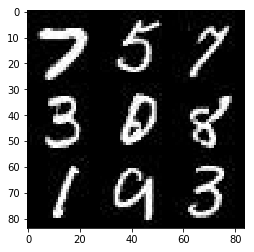

In [2]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

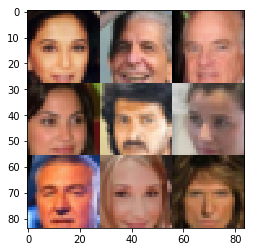

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32,  shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Try to test https://arxiv.org/pdf/1705.03387.pdf
# The network weights were initialized using Xavier initialization method [3], which improved the speed of convergence.
# [] X. Glorot and Y. Bengio. Understanding the difficulty of training deep feedforward neural networks. In Aistats, volume 9, pages 249–256, 2010.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# credit to https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/contrib/layers/python/layers/initializers.py
import math

from tensorflow.python.framework import dtypes
from tensorflow.python.ops import random_ops

def xavier_initializer(uniform=True, seed=None, dtype=dtypes.float32):
  """Returns an initializer performing "Xavier" initialization for weights.
  This function implements the weight initialization from:
  Xavier Glorot and Yoshua Bengio (2010):
           [Understanding the difficulty of training deep feedforward neural
           networks. International conference on artificial intelligence and
           statistics.](
           http://www.jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf)
  This initializer is designed to keep the scale of the gradients roughly the
  same in all layers. In uniform distribution this ends up being the range:
  `x = sqrt(6. / (in + out)); [-x, x]` and for normal distribution a standard
  deviation of `sqrt(3. / (in + out))` is used.
  Args:
    uniform: Whether to use uniform or normal distributed random initialization.
    seed: A Python integer. Used to create random seeds. See
          @{tf.set_random_seed} for behavior.
    dtype: The data type. Only floating point types are supported.
  Returns:
    An initializer for a weight matrix.
  """
  return variance_scaling_initializer(factor=1.0, mode='FAN_AVG',
                                      uniform=uniform, seed=seed, dtype=dtype)

xavier_initializer_conv2d = xavier_initializer


def variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False,
                                 seed=None, dtype=dtypes.float32):
  """Returns an initializer that generates tensors without scaling variance.
  When initializing a deep network, it is in principle advantageous to keep
  the scale of the input variance constant, so it does not explode or diminish
  by reaching the final layer. This initializer use the following formula:
  ```python
    if mode='FAN_IN': # Count only number of input connections.
      n = fan_in
    elif mode='FAN_OUT': # Count only number of output connections.
      n = fan_out
    elif mode='FAN_AVG': # Average number of inputs and output connections.
      n = (fan_in + fan_out)/2.0
      truncated_normal(shape, 0.0, stddev=sqrt(factor / n))
  ```
  * To get [Delving Deep into Rectifiers](
     http://arxiv.org/pdf/1502.01852v1.pdf), use (Default):<br/>
    `factor=2.0 mode='FAN_IN' uniform=False`
  * To get [Convolutional Architecture for Fast Feature Embedding](
     http://arxiv.org/abs/1408.5093), use:<br/>
    `factor=1.0 mode='FAN_IN' uniform=True`
  * To get [Understanding the difficulty of training deep feedforward neural
    networks](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf),
    use:<br/>
    `factor=1.0 mode='FAN_AVG' uniform=True.`
  * To get `xavier_initializer` use either:<br/>
    `factor=1.0 mode='FAN_AVG' uniform=True`, or<br/>
    `factor=1.0 mode='FAN_AVG' uniform=False`.
  Args:
    factor: Float.  A multiplicative factor.
    mode: String.  'FAN_IN', 'FAN_OUT', 'FAN_AVG'.
    uniform: Whether to use uniform or normal distributed random initialization.
    seed: A Python integer. Used to create random seeds. See
          @{tf.set_random_seed} for behavior.
    dtype: The data type. Only floating point types are supported.
  Returns:
    An initializer that generates tensors with unit variance.
  Raises:
    ValueError: if `dtype` is not a floating point type.
    TypeError: if `mode` is not in ['FAN_IN', 'FAN_OUT', 'FAN_AVG'].
  """
  if not dtype.is_floating:
    raise TypeError('Cannot create initializer for non-floating point type.')
  if mode not in ['FAN_IN', 'FAN_OUT', 'FAN_AVG']:
    raise TypeError('Unknow mode %s [FAN_IN, FAN_OUT, FAN_AVG]', mode)

  # pylint: disable=unused-argument
  def _initializer(shape, dtype=dtype, partition_info=None):
    """Initializer function."""
    if not dtype.is_floating:
      raise TypeError('Cannot create initializer for non-floating point type.')
    # Estimating fan_in and fan_out is not possible to do perfectly, but we try.
    # This is the right thing for matrix multiply and convolutions.
    if shape:
      fan_in = float(shape[-2]) if len(shape) > 1 else float(shape[-1])
      fan_out = float(shape[-1])
    else:
      fan_in = 1.0
      fan_out = 1.0
    for dim in shape[:-2]:
      fan_in *= float(dim)
      fan_out *= float(dim)
    if mode == 'FAN_IN':
      # Count only number of input connections.
      n = fan_in
    elif mode == 'FAN_OUT':
      # Count only number of output connections.
      n = fan_out
    elif mode == 'FAN_AVG':
      # Average number of inputs and output connections.
      n = (fan_in + fan_out) / 2.0
    if uniform:
      # To get stddev = math.sqrt(factor / n) need to adjust for uniform.
      limit = math.sqrt(3.0 * factor / n)
      return random_ops.random_uniform(shape, -limit, limit,
                                       dtype, seed=seed)
    else:
      # To get stddev = math.sqrt(factor / n) need to adjust for truncated.
      trunc_stddev = math.sqrt(1.3 * factor / n)
      return random_ops.truncated_normal(shape, 0.0, trunc_stddev, dtype,
                                         seed=seed)
  # pylint: enable=unused-argument

  return _initializer



def leaky_relu(x, alpha=0.1):
    """Leaky Rectified Linear Unit function.
    
    Parameters
    ----------
    x: ndarray like
    alpha: float
        optional default to 0.1
    
    Returns
    -------
    A Tensor.
    
    """
    return tf.maximum(x * alpha, x)
    
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # in: 28*28*num_channels out:14*14*64
        _ = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer=xavier_initializer())
        _ = leaky_relu(_, alpha=alpha)
        
        # in: 14*14*64 out:7*7*128
        _ = tf.layers.conv2d(_, 128, 5, strides=2, padding='SAME', kernel_initializer=xavier_initializer())
        _ = tf.layers.batch_normalization(_, training=True)
        _ = leaky_relu(_, alpha=alpha)
        
        # in: 7*7*128 out:4*4*256
        _ = tf.layers.conv2d(_, 256, 5, strides=2, padding='SAME', kernel_initializer=xavier_initializer())
        _ = tf.layers.batch_normalization(_, training=True)
        _ = leaky_relu(_, alpha=alpha)
        
        # Make it Flat
        # in: 4*4*256
        flat = tf.reshape(_, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # Dense layer
        _ = tf.layers.dense(z, 7*7*512, kernel_initializer=xavier_initializer())
        _ = tf.reshape(_, (-1, 7, 7, 512))
        _ = tf.layers.batch_normalization(_, training=is_train)
        _ = leaky_relu(_, alpha=alpha)
        
        # in: 7*7*512  out:14*14*256
        _ = tf.layers.conv2d_transpose(_, 256, 5, strides=2,   padding='same', kernel_initializer=xavier_initializer())
        _ = tf.layers.batch_normalization(_, training=is_train)
        _ = leaky_relu(_, alpha=alpha)
        
        # in: 14*14*256 out:14*14*128
        _ = tf.layers.conv2d_transpose(_, 128, 5, strides=1, padding='same', kernel_initializer=xavier_initializer())
        _ = tf.layers.batch_normalization(_, training=is_train)
        _ = leaky_relu(_, alpha=alpha)
        
        logits = tf.layers.conv2d_transpose(_, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=xavier_initializer())
        
        #  logits: 28*28*out_channel_dim
        
        output = tf.tanh(logits)
        
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    s = np.random.uniform(0.8, 1.0)  # https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * s))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # @see https://www.tensorflow.org/api_docs/python/tf/GraphKeys
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=50, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,  lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                
                

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...{}".format(epoch_i + 1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...50 Discriminator Loss: 1.9034... Generator Loss: 1.6957
Epoch 1/2...100 Discriminator Loss: 1.4677... Generator Loss: 1.1764


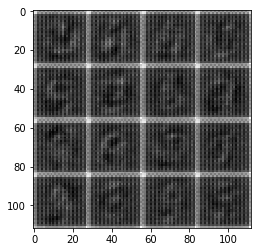

Epoch 1/2...150 Discriminator Loss: 1.1285... Generator Loss: 0.9788
Epoch 1/2...200 Discriminator Loss: 1.0981... Generator Loss: 1.1902


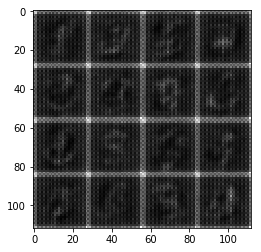

Epoch 1/2...250 Discriminator Loss: 1.3943... Generator Loss: 0.4797
Epoch 1/2...300 Discriminator Loss: 1.4699... Generator Loss: 0.4377


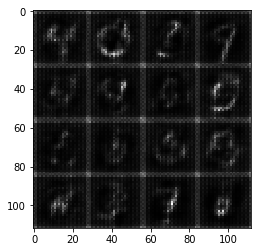

Epoch 1/2...350 Discriminator Loss: 1.6094... Generator Loss: 0.3744
Epoch 1/2...400 Discriminator Loss: 1.3011... Generator Loss: 1.2890


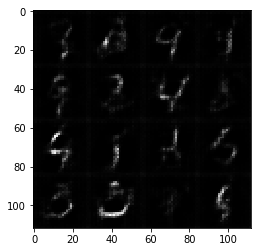

Epoch 1/2...450 Discriminator Loss: 1.4248... Generator Loss: 0.4607
Epoch 1/2...500 Discriminator Loss: 1.4071... Generator Loss: 0.4718


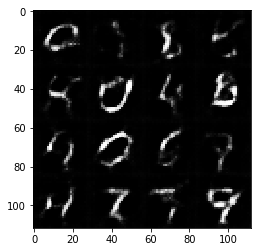

Epoch 1/2...550 Discriminator Loss: 1.3937... Generator Loss: 0.5428
Epoch 1/2...600 Discriminator Loss: 1.1652... Generator Loss: 1.1256


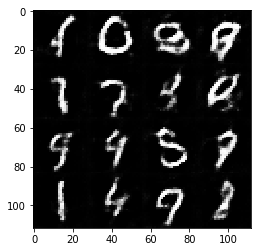

Epoch 1/2...650 Discriminator Loss: 1.1920... Generator Loss: 1.3336
Epoch 1/2...700 Discriminator Loss: 1.1786... Generator Loss: 0.9404


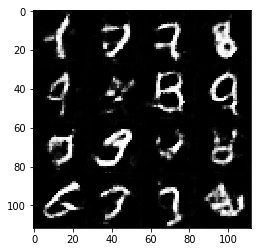

Epoch 1/2...750 Discriminator Loss: 1.2583... Generator Loss: 1.5671
Epoch 1/2...800 Discriminator Loss: 1.1720... Generator Loss: 1.1086


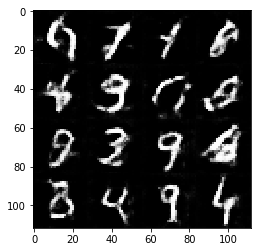

Epoch 1/2...850 Discriminator Loss: 1.1529... Generator Loss: 0.9101
Epoch 1/2...900 Discriminator Loss: 1.1369... Generator Loss: 0.7647


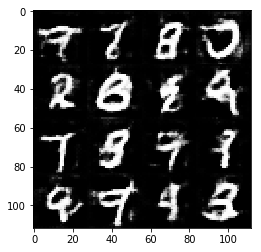

Epoch 2/2...950 Discriminator Loss: 1.0330... Generator Loss: 1.4305
Epoch 2/2...1000 Discriminator Loss: 2.0205... Generator Loss: 0.3215


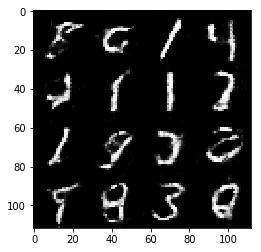

Epoch 2/2...1050 Discriminator Loss: 1.5516... Generator Loss: 0.4408
Epoch 2/2...1100 Discriminator Loss: 1.3516... Generator Loss: 0.5272


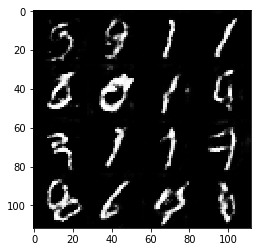

Epoch 2/2...1150 Discriminator Loss: 1.3320... Generator Loss: 0.5918
Epoch 2/2...1200 Discriminator Loss: 1.1054... Generator Loss: 0.7808


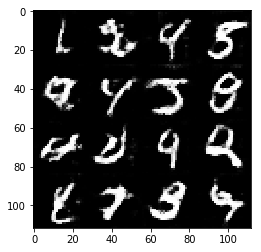

Epoch 2/2...1250 Discriminator Loss: 1.1281... Generator Loss: 0.7252
Epoch 2/2...1300 Discriminator Loss: 1.1585... Generator Loss: 0.6753


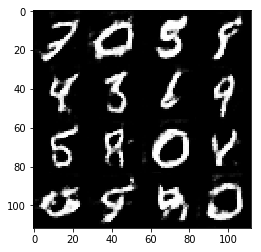

Epoch 2/2...1350 Discriminator Loss: 0.8779... Generator Loss: 1.2649
Epoch 2/2...1400 Discriminator Loss: 1.3875... Generator Loss: 2.0509


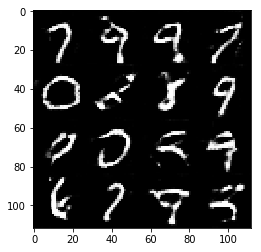

Epoch 2/2...1450 Discriminator Loss: 0.7929... Generator Loss: 1.4991
Epoch 2/2...1500 Discriminator Loss: 0.9782... Generator Loss: 0.9200


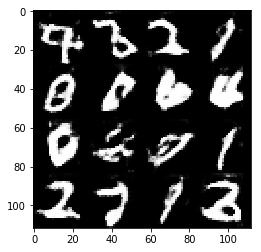

Epoch 2/2...1550 Discriminator Loss: 1.2315... Generator Loss: 0.6459
Epoch 2/2...1600 Discriminator Loss: 0.9341... Generator Loss: 1.0114


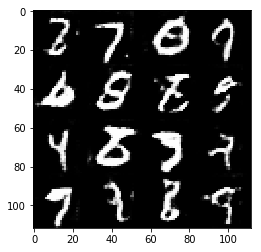

Epoch 2/2...1650 Discriminator Loss: 1.1345... Generator Loss: 1.2421
Epoch 2/2...1700 Discriminator Loss: 0.8351... Generator Loss: 1.1213


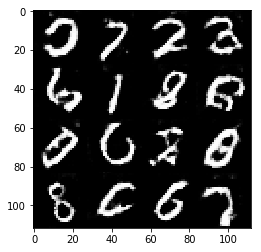

Epoch 2/2...1750 Discriminator Loss: 0.7608... Generator Loss: 1.3750
Epoch 2/2...1800 Discriminator Loss: 0.9604... Generator Loss: 0.9994


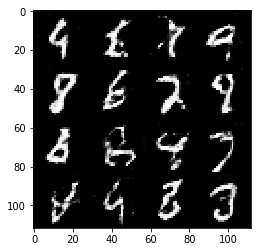

Epoch 2/2...1850 Discriminator Loss: 0.9526... Generator Loss: 1.1132


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, print_every=50, show_every=100)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...50 Discriminator Loss: 1.5261... Generator Loss: 1.3391
Epoch 1/1...100 Discriminator Loss: 1.7933... Generator Loss: 0.6489


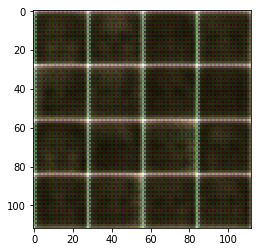

Epoch 1/1...150 Discriminator Loss: 1.5162... Generator Loss: 0.6048
Epoch 1/1...200 Discriminator Loss: 1.5862... Generator Loss: 0.5311


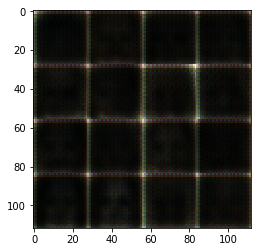

Epoch 1/1...250 Discriminator Loss: 1.3980... Generator Loss: 0.6782
Epoch 1/1...300 Discriminator Loss: 1.4019... Generator Loss: 0.8200


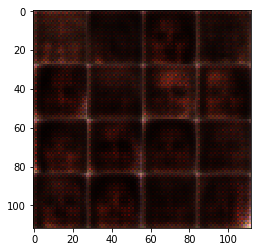

Epoch 1/1...350 Discriminator Loss: 1.4461... Generator Loss: 0.9243
Epoch 1/1...400 Discriminator Loss: 1.2206... Generator Loss: 0.9894


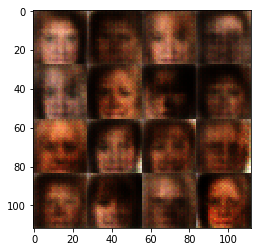

Epoch 1/1...450 Discriminator Loss: 1.3947... Generator Loss: 0.7330
Epoch 1/1...500 Discriminator Loss: 1.1838... Generator Loss: 1.1766


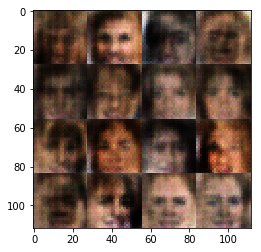

Epoch 1/1...550 Discriminator Loss: 1.2696... Generator Loss: 1.0308
Epoch 1/1...600 Discriminator Loss: 1.5835... Generator Loss: 1.8891


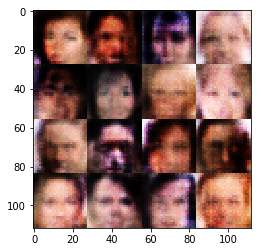

Epoch 1/1...650 Discriminator Loss: 1.0282... Generator Loss: 1.5237
Epoch 1/1...700 Discriminator Loss: 1.4065... Generator Loss: 0.4869


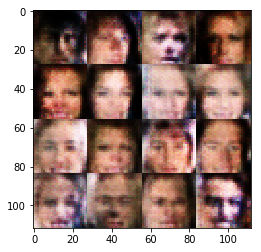

Epoch 1/1...750 Discriminator Loss: 1.0871... Generator Loss: 0.8400
Epoch 1/1...800 Discriminator Loss: 1.3093... Generator Loss: 3.0692


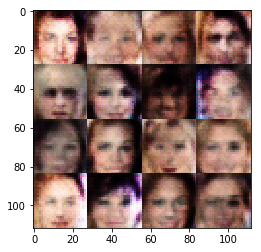

Epoch 1/1...850 Discriminator Loss: 1.1677... Generator Loss: 1.3330
Epoch 1/1...900 Discriminator Loss: 1.1169... Generator Loss: 1.1177


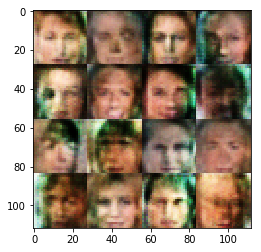

Epoch 1/1...950 Discriminator Loss: 1.3584... Generator Loss: 0.6813
Epoch 1/1...1000 Discriminator Loss: 1.3871... Generator Loss: 0.6346


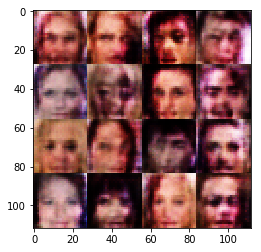

Epoch 1/1...1050 Discriminator Loss: 1.4171... Generator Loss: 0.5914
Epoch 1/1...1100 Discriminator Loss: 1.4611... Generator Loss: 0.5325


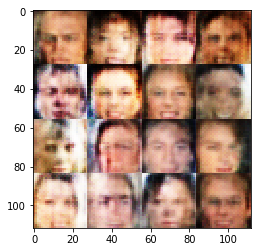

Epoch 1/1...1150 Discriminator Loss: 1.3210... Generator Loss: 1.5313
Epoch 1/1...1200 Discriminator Loss: 1.3808... Generator Loss: 0.8344


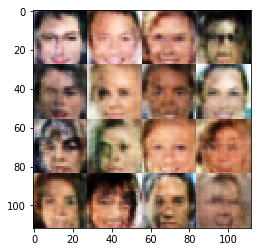

Epoch 1/1...1250 Discriminator Loss: 1.1936... Generator Loss: 0.9946
Epoch 1/1...1300 Discriminator Loss: 1.2193... Generator Loss: 0.8116


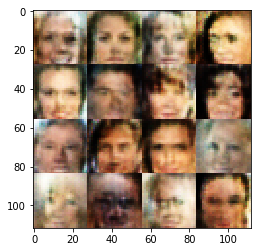

Epoch 1/1...1400 Discriminator Loss: 1.2238... Generator Loss: 0.7600


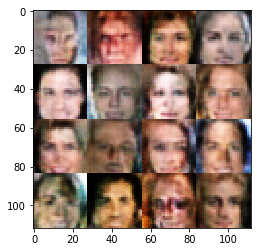

Epoch 1/1...1450 Discriminator Loss: 1.4595... Generator Loss: 0.5115
Epoch 1/1...1500 Discriminator Loss: 1.0549... Generator Loss: 1.1221


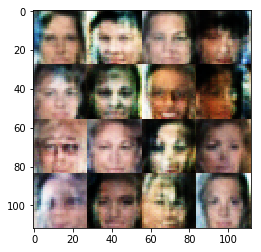

Epoch 1/1...1550 Discriminator Loss: 1.1444... Generator Loss: 1.2011
Epoch 1/1...1600 Discriminator Loss: 1.2015... Generator Loss: 0.7795


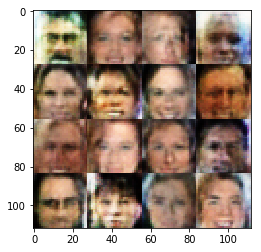

Epoch 1/1...1650 Discriminator Loss: 1.2200... Generator Loss: 1.2127
Epoch 1/1...1700 Discriminator Loss: 1.2320... Generator Loss: 0.7692


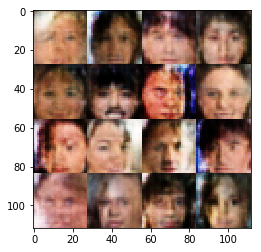

Epoch 1/1...1750 Discriminator Loss: 0.9933... Generator Loss: 0.9682
Epoch 1/1...1800 Discriminator Loss: 1.0952... Generator Loss: 0.9593


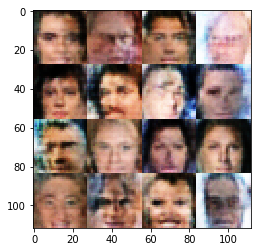

Epoch 1/1...1850 Discriminator Loss: 1.1536... Generator Loss: 0.9139
Epoch 1/1...1900 Discriminator Loss: 1.1410... Generator Loss: 1.0370


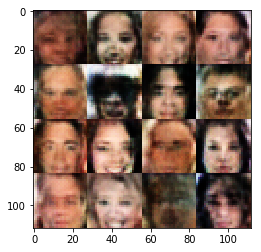

Epoch 1/1...1950 Discriminator Loss: 1.2822... Generator Loss: 0.7076
Epoch 1/1...2000 Discriminator Loss: 1.2895... Generator Loss: 0.7163


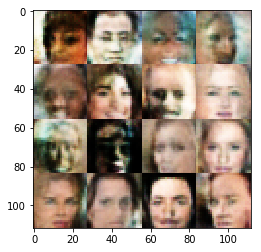

Epoch 1/1...2050 Discriminator Loss: 1.3097... Generator Loss: 0.6856
Epoch 1/1...2100 Discriminator Loss: 1.1248... Generator Loss: 1.3934


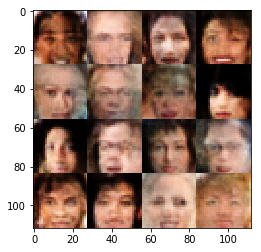

Epoch 1/1...2150 Discriminator Loss: 1.0845... Generator Loss: 1.0403
Epoch 1/1...2200 Discriminator Loss: 1.3003... Generator Loss: 0.6975


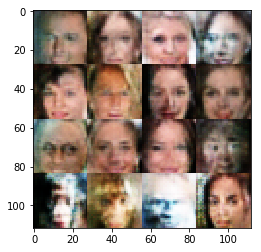

Epoch 1/1...2250 Discriminator Loss: 1.3252... Generator Loss: 0.6149
Epoch 1/1...2300 Discriminator Loss: 0.8851... Generator Loss: 1.6644


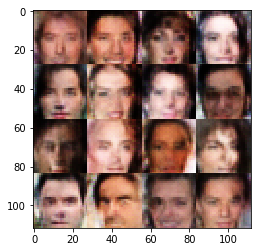

Epoch 1/1...2350 Discriminator Loss: 1.1645... Generator Loss: 0.7914
Epoch 1/1...2400 Discriminator Loss: 1.4611... Generator Loss: 0.4817


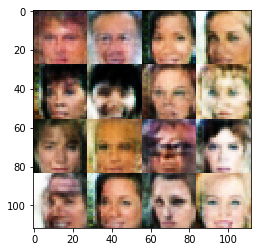

Epoch 1/1...2450 Discriminator Loss: 1.3602... Generator Loss: 0.6265
Epoch 1/1...2500 Discriminator Loss: 1.2477... Generator Loss: 0.6000


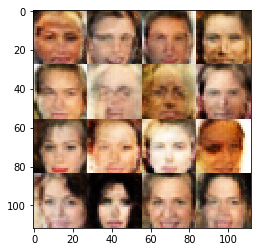

Epoch 1/1...2550 Discriminator Loss: 1.4394... Generator Loss: 0.5989
Epoch 1/1...2600 Discriminator Loss: 1.2702... Generator Loss: 0.7720


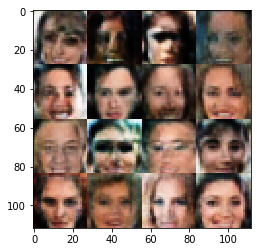

Epoch 1/1...2650 Discriminator Loss: 1.1920... Generator Loss: 1.2618
Epoch 1/1...2700 Discriminator Loss: 1.1597... Generator Loss: 1.0997


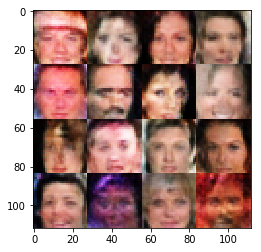

Epoch 1/1...2750 Discriminator Loss: 1.3327... Generator Loss: 0.6796
Epoch 1/1...2800 Discriminator Loss: 1.1046... Generator Loss: 1.0417


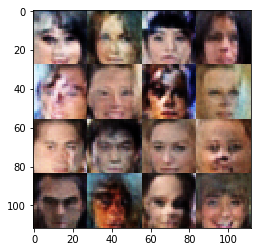

Epoch 1/1...2850 Discriminator Loss: 1.4461... Generator Loss: 0.4709
Epoch 1/1...2900 Discriminator Loss: 1.2069... Generator Loss: 0.8699


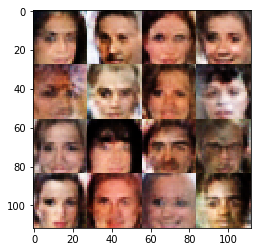

Epoch 1/1...2950 Discriminator Loss: 1.2236... Generator Loss: 0.8826
Epoch 1/1...3000 Discriminator Loss: 1.1947... Generator Loss: 0.8331


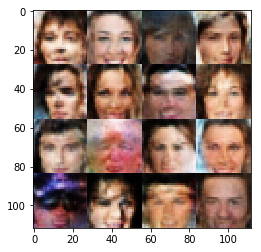

Epoch 1/1...3050 Discriminator Loss: 1.2209... Generator Loss: 1.1158
Epoch 1/1...3100 Discriminator Loss: 1.2183... Generator Loss: 0.6988


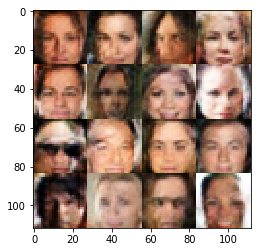

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every=50, show_every=100)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.